# SPYN - III phase AC motor control

<div class="alert bg-primary">This notebook will show control of a 3-phase AC motor using the EDPS (The Electric Drive Power Stage (EDPS) Board, a Trenz Electronic TEC0053, which is connected to the PYNQ-Z1 controller board for the evaluation..</div>

![](./motor.png)

 ## Objectives
 
 * [Access to Motor Control Parameters](#Step-2:-Instantiate-the-motor-control-object )
 * [Request Status Information of the Motor](#Step-4:-Read-status-registers)
 * [Programmatic Control of Motor](#Programmatic-Control-of-Motor)
 * [Continuous Status Capture from the Motor](#Step-5:-Allocate-DMA-for-stream-capture)
 * [Plots to Visualize Data Captured](#Plotting)
 * [Storing Captured Data for Analytics](#Dataframes-for-analytics)
 * [Live Interactive Plots to Investigate Data](#DASH-Demo)
 

### Step 1: Download the `EDDP` bitstream

In [1]:
from pynq import Overlay
from pynq import MMIO
import numpy as np

overlay = Overlay("eddp.bit")
overlay.download()

### Step 2: Instantiate the motor control object 
#### Set the motor mode

In [2]:
from motor_controller import *
from constants import *

motor = Motor_Controller()
print(f'Available motor modes : {motor.motor_modes}')

Available motor modes : ('reset_mode', 'torque_mode', 'rpm_mode')


In [3]:
motor.set_mode('reset_mode')

#### Available control and status IP blocks

In [4]:
print(f'Memory mapped IO blocks : {motor.mmio_blocks}')

Memory mapped IO blocks : {'control_axi_block': '0x43c00000', 'capture_axi_block': '0x43c10000'}


### Step 3: Set motor control mode and control using sliders

In [5]:
from ipywidgets import interact, interactive, HBox, VBox
import ipywidgets as widgets

text = {'Motor': 'success', 'Forward': 'info', 'Reverse': 'warning'}
buttons, colors = list(text.keys()), list(text.values())

toggle = [
    widgets.ToggleButton(description=f'{buttons[i]}',
                         button_style=f'{colors[i]}')
    for i in range(3)]
mode = widgets.Dropdown(options=['Speed', 'Current'])


def clicked(toggle_0=toggle[0], mode=mode, toggle_1=toggle[1],
            toggle_2=toggle[2], RPM=None, Torque=None):
    if toggle_0:
        if mode == 'Speed':
            motor.set_mode('rpm_mode')
            motor.set_rpm(RPM)
        elif mode == 'Current':
            motor.set_mode('torque_mode')
            motor.set_torque(Torque)
    else:
         motor.stop()


w = interactive(clicked,
                RPM=widgets.IntSlider(min=-5000, max=5000, step=1, value=1000),
                Torque=widgets.IntSlider(min=-400, max=400, step=1, value=0))
VBox([HBox(w.children[:2]), w.children[2], w.children[3], w.children[4],
      w.children[5]])


[Back to Objectives](#Objectives)

### Step 4: Read status registers

In [6]:
motor_status = [(motor._read_controlreg(i + ANGLE.offset)) for i in
                range(0, 16, 4)]
high_sp, low_sp = bytesplit(motor_status[1])
high_id, low_id = bytesplit(motor_status[2])
high_iq, low_iq = bytesplit(motor_status[3])

print(f'Angle in degrees : {motor_status[0] * 0.36}')
print(f'Angle in steps per thousand: {(motor_status[0])}')
print(f'Id : {np.int16(low_id) * 0.00039} Amp')
print(f'Iq : {np.int16(low_iq) * 0.00039} Amp')
print(f'Speed in RPM : {-(np.int16(low_sp))}')


Angle in degrees : 69.48
Angle in steps per thousand: 193
Id : 0.051089999999999997 Amp
Iq : 0.14547 Amp
Speed in RPM : 2000


[Back to Objectives](#Objectives)

### Programmatic Control of Motor

In [ ]:
import time
motor.set_mode('rpm_mode')
for i in range(2):
        motor.set_rpm(1000)
        time.sleep(1)
        motor.set_rpm(0)
        time.sleep(2)
        motor.set_rpm(-50)
        time.sleep(2)
        motor.set_rpm(0)
        time.sleep(2)
motor.stop()    

[Back to Objectives](#Objectives)

###  Set capture mode

In [7]:
print(f'Available stream capture modes : {motor.motor_capture_modes}')

Available stream capture modes : ('ia_ib_angle_rpm', 'id_iq', 'vd_vq')


In [8]:
motor.capture_mode('vd_vq')

### Step 5: Allocate DMA for stream capture

In [9]:
from pynq import Xlnk

xlnk = Xlnk()
input_buffer = xlnk.cma_array(shape=(256,), dtype=np.uint8)

capture_address = input_buffer.physical_address

In [10]:
print(f'Physical Address of data stream capture: {hex(capture_address)}')

Physical Address of data stream capture: 0x16846000


### Step 6: Log stream data as per control mode

In [12]:
from pynq import MMIO

# capture_count = int(input('Enter capture count: '))
capture_count = 2000

def continuous_capture(capture_count):    
    mmio_stream = MMIO(capture_address, 256)
    cap_list = [([]) for i in range(4)]
    for _ in range(capture_count):
        motor.stream_capture(capture_address)
        for i in range(4, 260, 4):
            stream = mmio_stream.read(i - 4, 4)
            highbits, lowbits = bytesplit(stream)
            if (i % 8 != 0):
                cap_list[0].extend([(np.int16(lowbits))])
                cap_list[1].extend([(np.int16(highbits))])
            else:
                cap_list[2].extend([(np.int16(lowbits))])
                cap_list[3].extend([(np.int16(highbits))])
    return cap_list

cap_list = continuous_capture(capture_count)
Ia, Ib, angle, rpm  = cap_list[0], cap_list[1], cap_list[3], cap_list[2]

current_Ia = np.array(Ia) * 0.00036
current_Ib = np.array(Ib) * 0.00036
        

[Back to Objectives](#Objectives)

### Step 7: Plotting

 #### Ia vs Sample count

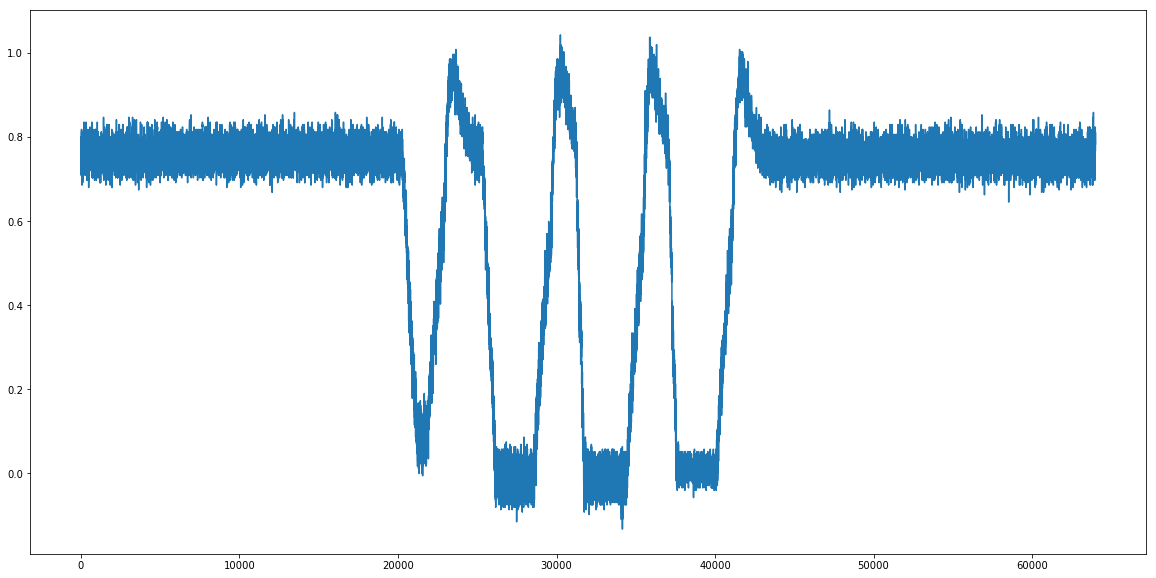

In [13]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(current_Ia)
plt.show()

#### Ib vs Sample count

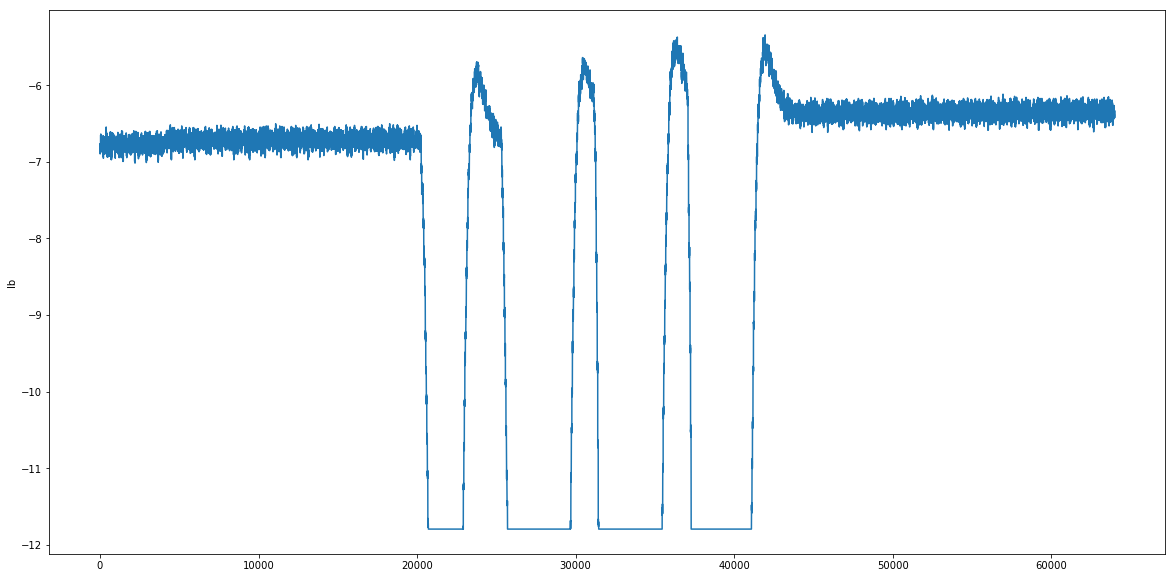

In [14]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(current_Ib)
plt.ylabel('Ib')
plt.show()

#### Ia vs Ib

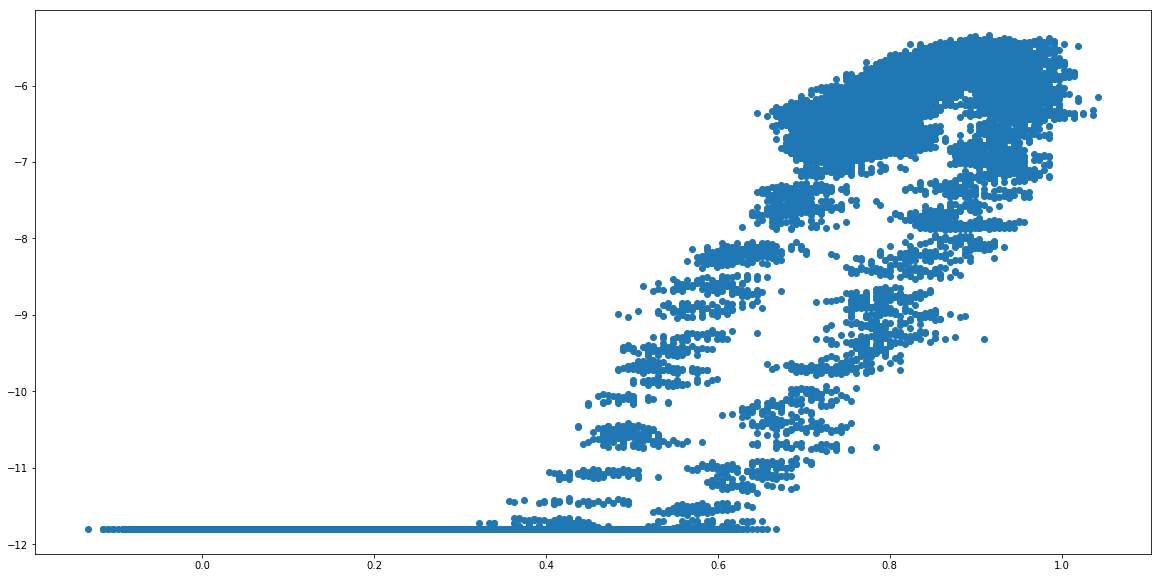

In [15]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.scatter(current_Ia, current_Ib)
plt.show()

#### Angle vs Sample count

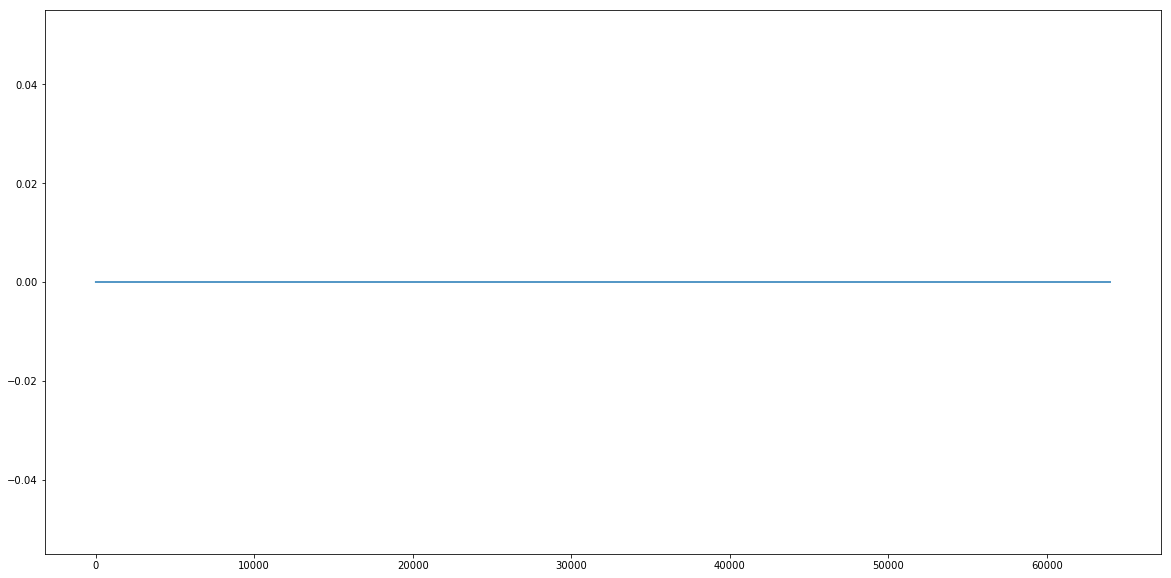

In [16]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(angle)
plt.show()

#### RPM vs Sample count

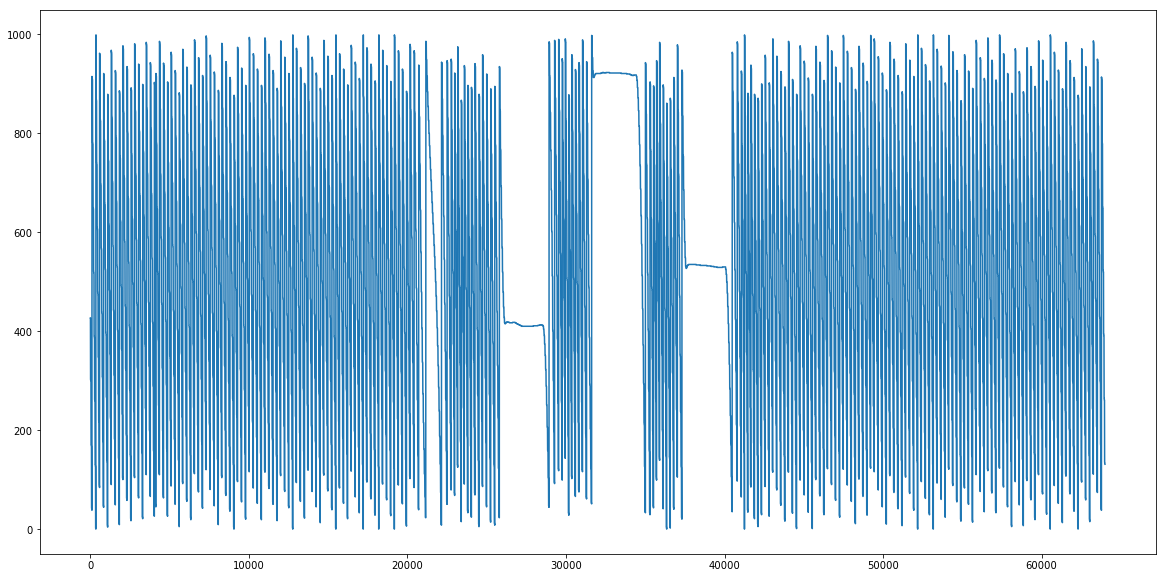

In [17]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(rpm)
plt.show()

[Back to Objectives](#Objectives)

### Step 8: Stop motor and reset xlnk

In [ ]:
xlnk.xlnk_reset()
motor.stop()

### Dataframes for analytics

In [ ]:
import pandas as pd

data = {'Ia' : current_Ia,
        'Ib' : current_Ib,
        'angle':cap_list[3],
        'rpm':  cap_list[2]}

df = pd.DataFrame(data, columns = ['Ia', 'Ib', 'angle', 'rpm'])
df

[Back to Objectives](#Objectives)

### DASH Demo